# Match Collection Data

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from datetime import datetime
from matplotlib.animation import FuncAnimation, FFMpegWriter


# Connect to DuckDB 
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

con.execute("""
CREATE OR REPLACE TABLE summary AS
SELECT *
FROM read_csv_auto('data/summary.csv')
""")

DuckDB ready


In [50]:
#Afficher les table disponibles
print(con.execute("SHOW TABLES;").fetchdf())

                       name
0           extreme_vitesse
1                 mapping_v
2         outlier_sequences
3           outliers_points
4                   summary
5                  tracking
6            tracking_clean
7        tracking_corrected
8            tracking_games
9           tracking_player
10          tracking_pseudo
11  tracking_pseudo_cleaned
12    tracking_pseudo_final
13              tracking_v1
14              tracking_v2


In [73]:
#Create a table with all matches
con.execute("""
    CREATE OR REPLACE TABLE tracking_games AS
SELECT
    *
FROM tracking_clean
WHERE session_type = 'game';
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [74]:
#Afficher colonnes de la table tracking_games
print(con.execute("PRAGMA table_info('tracking_games');").fetchdf())

   cid           name       type  notnull dflt_value     pk
0    0  player_pseudo     BIGINT    False       None  False
1    1   session_type    VARCHAR    False       None  False
2    2   session_date       DATE    False       None  False
3    3      sensor_id    INTEGER    False       None  False
4    4       time_utc  TIMESTAMP    False       None  False
5    5          x_pos     DOUBLE    False       None  False
6    6          y_pos     DOUBLE    False       None  False
7    7      speed_kmh     DOUBLE    False       None  False


In [77]:
#Afficher colonnes de la table summary
print(con.execute("PRAGMA table_info('summary');").fetchdf())

    cid                    name       type  notnull dflt_value     pk
0     0                column00     BIGINT    False       None  False
1     1                  Sensor     BIGINT    False       None  False
2     2               last_name    VARCHAR    False       None  False
3     3              first_name    VARCHAR    False       None  False
4     4                    date  TIMESTAMP    False       None  False
5     5                    type    VARCHAR    False       None  False
6     6                position    VARCHAR    False       None  False
7     7        feature_distance    VARCHAR    False       None  False
8     8     feature_d_speed_0_5    VARCHAR    False       None  False
9     9    feature_d_speed_5_10    VARCHAR    False       None  False
10   10   feature_d_speed_10_15    VARCHAR    False       None  False
11   11   feature_d_speed_15_21    VARCHAR    False       None  False
12   12   feature_d_speed_21_24    VARCHAR    False       None  False
13   13   feature_d_

## Réseaux de neurones

In [80]:
match = '2020-02-01'
#Créer un dataframe player_pseudo, sensor_id et position pour ce match
df_match_players = con.execute(f"""
SELECT DISTINCT
    tg.player_pseudo,
    tg.sensor_id,
    s.position
FROM tracking_games tg
LEFT JOIN summary s
    ON tg.sensor_id = s.Sensor
   AND DATE(tg.session_date) = DATE(s.date)
WHERE DATE(tg.session_date) = '{match}'
ORDER BY tg.player_pseudo
""").df()
print(df_match_players)


    player_pseudo  sensor_id         position
0               1         14  center midfield
1               6         10   center forward
2               9         23      center back
3              10          4      center back
4              11         17       right back
5              14         13  center midfield
6              19         12        left back
7              24         11     left forward
8              25         20   center forward
9              34          5      center back
10             35         77   center forward
11             36          9       ran center
12             39         21   center forward


In [81]:
# Joueur et match
player_pseudo = df_match_players['player_pseudo'].iloc[0]

# Récupérer les données
df_player = con.execute(f"""
SELECT * 
FROM tracking_games
WHERE DATE(session_date) = '{match}'
  AND player_pseudo = '{player_pseudo}'
ORDER BY session_date
""").df()

# Échantillonner si tu veux moins de points
df_player_sampled = df_player.iloc[::10, :]

print(df_player_sampled['x_pos'].min(), df_player_sampled['x_pos'].max())
print(df_player_sampled['y_pos'].min(), df_player_sampled['y_pos'].max())

1.096465 105.699708
-1.472481 70.403083


### Fréquence d'échantillonnage

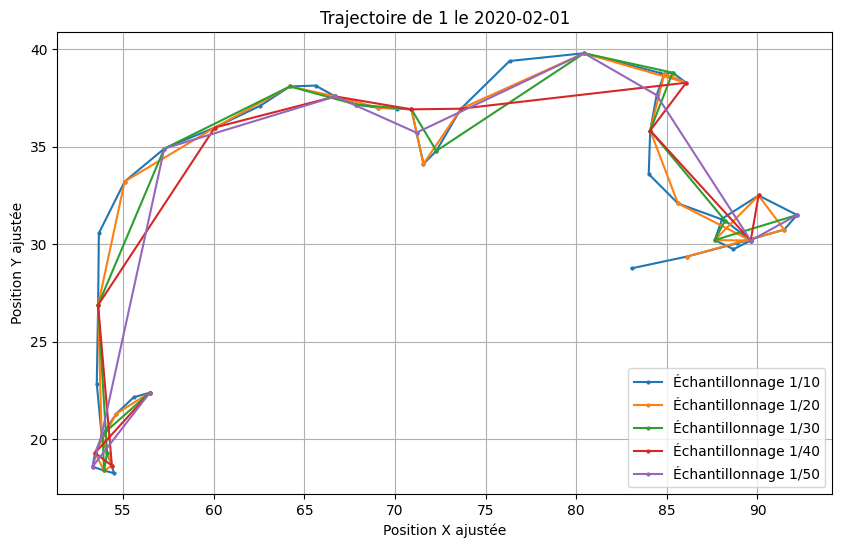

In [82]:
# Joueur et match
player_pseudo = df_match_players['player_pseudo'].iloc[0]
# Récupérer les données
df_player = con.execute(f"""
SELECT * 
FROM tracking_games
WHERE DATE(session_date) = '{match}'
  AND player_pseudo = '{player_pseudo}'
ORDER BY session_date
""").df()

# Échantillonner si tu veux moins de points de différents intervalles 0 à
duree = 50
df10_player_sampled = df_player.iloc[::10, :].iloc[:duree]
df20_player_sampled = df_player.iloc[::20, :].iloc[:duree//2]
df30_player_sampled = df_player.iloc[::30, :].iloc[:duree//3]
df40_player_sampled = df_player.iloc[::40, :].iloc[:duree//4]
df50_player_sampled = df_player.iloc[::50, :].iloc[:duree//5]
# Recaler le point de départ à 0,0
x_min = df_player_sampled['x_pos'].min()
y_min = df_player_sampled['y_pos'].min()
df_player_sampled['x_pos_adj'] = df_player_sampled['x_pos'] - x_min
df_player_sampled['y_pos_adj'] = df_player_sampled['y_pos'] - y_min

# Tracer la trajectoire
plt.figure(figsize=(10, 6))
plt.plot(df10_player_sampled['x_pos'] - x_min, df10_player_sampled['y_pos'] - y_min, marker='o', markersize=2, label='Échantillonnage 1/10')
plt.plot(df20_player_sampled['x_pos'] - x_min, df20_player_sampled['y_pos'] - y_min, marker='o', markersize=2, label='Échantillonnage 1/20')
plt.plot(df30_player_sampled['x_pos'] - x_min, df30_player_sampled['y_pos'] - y_min, marker='o', markersize=2, label='Échantillonnage 1/30')
plt.plot(df40_player_sampled['x_pos'] - x_min, df40_player_sampled['y_pos'] - y_min, marker='o', markersize=2, label='Échantillonnage 1/40')
plt.plot(df50_player_sampled['x_pos'] - x_min, df50_player_sampled['y_pos'] - y_min, marker='o', markersize=2, label='Échantillonnage 1/50')
plt.title(f'Trajectoire de {player_pseudo} le {match}')
plt.xlabel('Position X ajustée')
plt.ylabel('Position Y ajustée')
plt.legend()
plt.grid()
plt.show()



    player_pseudo  sensor_id         position
0               1         14  center midfield
1               6         10   center forward
2               9         23      center back
3              10          4      center back
4              11         17       right back
5              14         13  center midfield
6              19         12        left back
7              24         11     left forward
8              25         20   center forward
9              34          5      center back
10             35         77   center forward
11             36          9       ran center
12             39         21   center forward


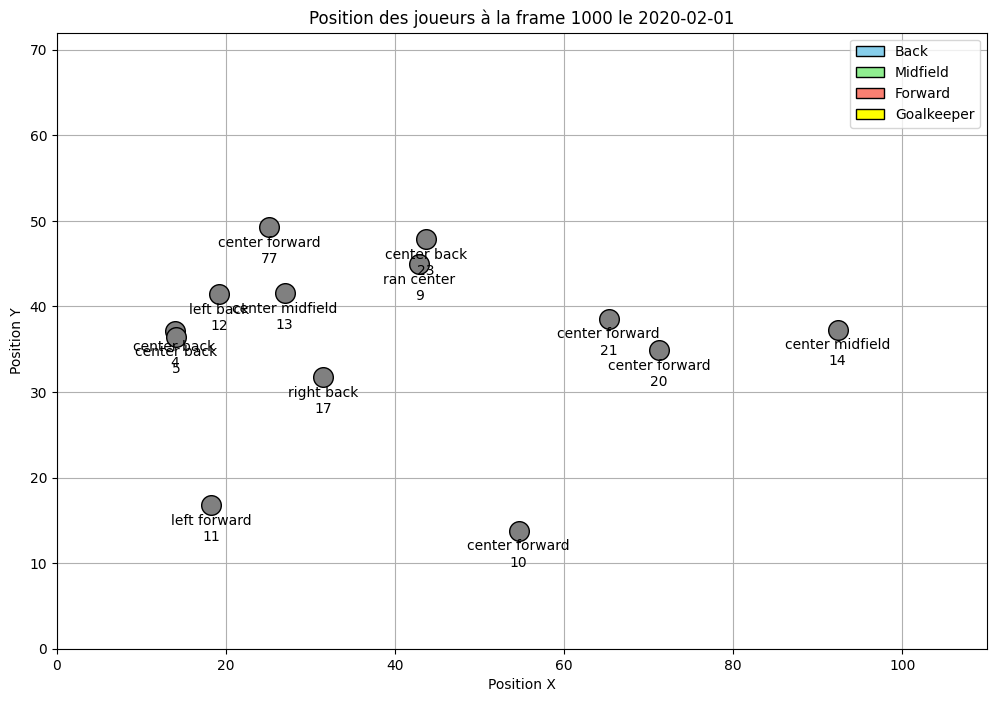

In [83]:
# Récupérer les défenseurs
all_positions = df_match_players[df_match_players['position'].notna()]
print(all_positions)

# Choisir le temps que tu veux afficher (ex: 50ème frame)
frame_to_plot = 1000

# Créer la figure
plt.figure(figsize=(12, 8))

# Définir des couleurs par poste
poste_colors = {
    'back': 'skyblue',
    'midfield': 'lightgreen',
    'forward': 'salmon',
    'goalkeeper': 'yellow'
}

# Boucler sur chaque joueur
for _, row in all_positions.iterrows():
    player_pseudo = row['player_pseudo']
    player_position = row['position'].lower()
    sensor_id = row['sensor_id']  # Récupérer le sensor_id
    
    # Récupérer les données du joueur
    df_player = con.execute(f"""
        SELECT * 
        FROM tracking_games
        WHERE DATE(session_date) = '{match}'
          AND player_pseudo = '{player_pseudo}'
        ORDER BY session_date
    """).df()
    
    if len(df_player) <= frame_to_plot:
        continue  # Ignorer si pas assez de points
    
    # Position du joueur à l'instant choisi
    x = df_player.iloc[frame_to_plot]['x_pos']
    y = df_player.iloc[frame_to_plot]['y_pos']
    
    # Choisir la couleur selon le poste
    color = poste_colors.get(player_position, 'gray')
    
    # Tracer le joueur sous forme de cercle
    plt.scatter(x, y, s=200, edgecolor='black', facecolor=color, zorder=3)
    
    # Ajouter le poste et le sensor_id en dessous
    plt.text(x, y - 1, f"{player_position}\n{sensor_id}", ha='center', va='top', fontsize=10, zorder=4)

# Ajouter des infos sur le graphique
plt.title(f'Position des joueurs à la frame {frame_to_plot} le {match}')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.xlim(0, 110)  # Dimensions approximatives du terrain
plt.ylim(0, 72)
plt.grid(True)

# Créer une légende par poste
legend_elements = [Patch(facecolor=color, edgecolor='black', label=poste.capitalize()) for poste, color in poste_colors.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

   player_pseudo  sensor_id     position
2              9         23  center back
3             10          4  center back
4             11         17   right back
6             19         12    left back
9             34          5  center back


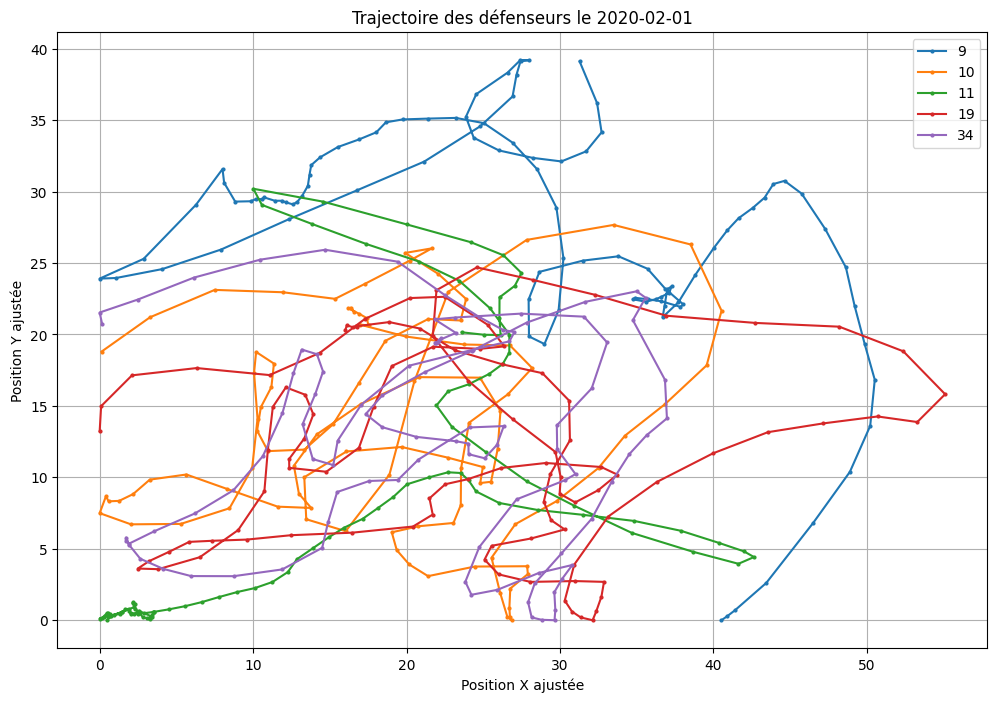

In [84]:
# Tracer des défenseurs
#Récupérer les données des défenseurs qui ont 'back' dans position
defender_positions = df_match_players[df_match_players['position'].str.contains('back', case=False, na=False)]
print(defender_positions)

# Créer la figure
plt.figure(figsize=(12, 8))

# Boucler sur chaque défenseur
for player_pseudo in defender_positions['player_pseudo']:
    # Récupérer les données du joueur
    df_player = con.execute(f"""
        SELECT * 
        FROM tracking_games
        WHERE DATE(session_date) = '{match}'
          AND player_pseudo = '{player_pseudo}'
        ORDER BY session_date
    """).df()
    
# Échantillonner si tu veux moins de points de différents intervalles 0 à


 # Échantillonner si nécessaire
    duree = 100  # nombre maximal de points
    df_sampled = df_player.iloc[::10, :].iloc[:duree]
    if len(df_sampled) == 0:
        continue  # Ignorer si pas de données

    # Recaler le point de départ à (0,0)
    x_min = df_sampled['x_pos'].min()
    y_min = df_sampled['y_pos'].min()
    df_sampled['x_pos_adj'] = df_sampled['x_pos'] - x_min
    df_sampled['y_pos_adj'] = df_sampled['y_pos'] - y_min

    # Tracer la trajectoire
    plt.plot(df_sampled['x_pos_adj'], df_sampled['y_pos_adj'], marker='o', markersize=2, label=player_pseudo)

# Ajouter des infos sur le graphique
plt.title(f'Trajectoire des défenseurs le {match}')
plt.xlabel('Position X ajustée')
plt.ylabel('Position Y ajustée')
plt.legend()
plt.grid()
plt.show()

   player_pseudo  sensor_id     position
2              9         23  center back
3             10          4  center back
4             11         17   right back
6             19         12    left back
9             34          5  center back
Animation enregistrée : defenseurs_deplacement.mp4


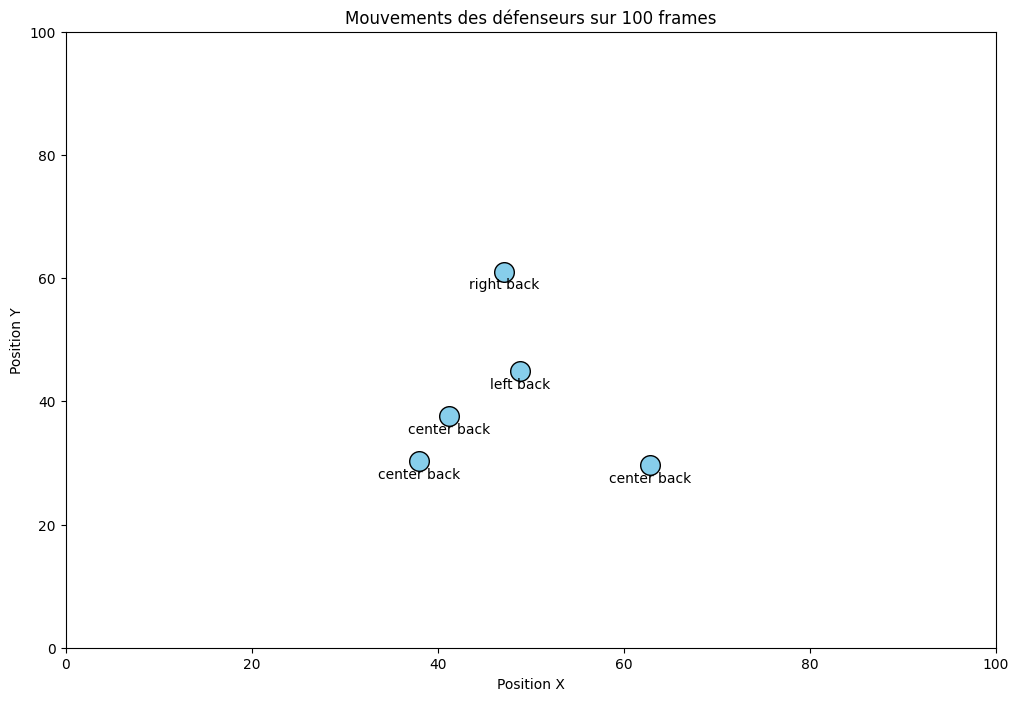

In [85]:
# Récupérer les défenseurs
defender_positions = df_match_players[df_match_players['position'].str.contains('back', case=False, na=False)]
print(defender_positions)

# Choisir le temps que tu veux afficher (ex: 50ème frame)
n_frames = 100

# Récupérer les données de tous les défenseurs
players_data = {}
for _, row in defender_positions.iterrows():
    player_pseudo = row['player_pseudo']
    player_position = row['position']
    
    df_player = con.execute(f"""
        SELECT * 
        FROM tracking_games
        WHERE DATE(session_date) = '{match}'
          AND player_pseudo = '{player_pseudo}'
        ORDER BY session_date
    """).df()
    
    # Limiter à n_frames si le joueur a plus de points
    df_player = df_player.iloc[:n_frames]
    
    if len(df_player) == 0:
        continue
    
    players_data[player_pseudo] = {
        'position': player_position,
        'x': df_player['x_pos'].values,
        'y': df_player['y_pos'].values
    }

# Créer la figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 100)  # Ajuster selon dimensions terrain
ax.set_ylim(0, 100)
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_title(f'Mouvements des défenseurs sur {n_frames} frames')

# Initialiser les cercles et textes
circles = {}
texts = {}
for player, data in players_data.items():
    circle = ax.scatter(data['x'][0], data['y'][0], s=200, edgecolor='black', facecolor='skyblue', zorder=3)
    text = ax.text(data['x'][0], data['y'][0]-1, data['position'], ha='center', va='top', fontsize=10, zorder=4)
    circles[player] = circle
    texts[player] = text

# Fonction d'update pour l'animation
def update(frame):
    for player, data in players_data.items():
        if frame < len(data['x']):
            circles[player].set_offsets([data['x'][frame], data['y'][frame]])
            texts[player].set_position((data['x'][frame], data['y'][frame]-1))
    return list(circles.values()) + list(texts.values())

# Créer l'animation
ani = FuncAnimation(fig, update, frames=n_frames, interval=100, blit=True)
ani.save("defenseurs_deplacement.mp4", writer=FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800))
print("Animation enregistrée : defenseurs_deplacement.mp4")
plt.show()


## Top 5

In [86]:
#Calculer les distances totales parcourues par chaque joueur pendant le match

def distance(match,top):
    distances = {}
    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']
        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
            AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()
        
        if len(df_player) < 2:
            distances[player_pseudo] = 0.0
            continue
        
        # Calculer la distance totale parcourue
        dx = df_player['x_pos'].diff().fillna(0)
        dy = df_player['y_pos'].diff().fillna(0)
        total_distance = np.sqrt(dx**2 + dy**2).sum()
        distances[player_pseudo] = total_distance
    # Afficher les distances
    print(f"Top {top} distances parcourues le {match}:")
    for player, dist in sorted(distances.items(), key=lambda item: item[1], reverse=True)[:top]:
        print(f"{player}: {dist:.2f} m")

def vitesse_max(match, top):
    vitesses = {}
    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']
        
        # Récupérer les données du joueur
        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
              AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()
        
        if len(df_player) < 2:
            vitesses[player_pseudo] = 0.0
            continue
        
        # Calculer la vitesse maximale
        max_speed = df_player['speed_kmh'].max()
        vitesses[player_pseudo] = max_speed

    # Afficher les vitesses
    print(f"Top {top} vitesses maximales le {match}:")
    for player, speed in sorted(vitesses.items(), key=lambda item: item[1], reverse=True)[:top]:
        print(f"{player}: {speed:.2f} km/h")

def acceleration_max(match, top=5):
    """
    Calcule l'accélération maximale de chaque joueur pour un match donné,
    en supposant une fréquence de 10 Hz (dt = 0.1 s).
    
    Paramètres :
    - match : date du match (str, format 'YYYY-MM-DD')
    - top : nombre de joueurs à afficher
    
    Retourne :
    - dict avec {player_pseudo: acceleration_max en m/s²}
    """
    accelerations = {}
    dt = 10  # secondes, fréquence 10 Hz
    
    for _, row in df_match_players.iterrows():
        player_pseudo = row['player_pseudo']
        
        # Récupérer les données du joueur
        df_player = con.execute(f"""
            SELECT * 
            FROM tracking_games
            WHERE DATE(session_date) = '{match}'
              AND player_pseudo = '{player_pseudo}'
            ORDER BY session_date
        """).df()
        
        if len(df_player) < 2:
            accelerations[player_pseudo] = 0.0
            continue
        
        # Différences de position
        dx = df_player["x_pos"].diff().fillna(0)
        dy = df_player["y_pos"].diff().fillna(0)
        
        # Vitesse instantanée
        speeds = np.sqrt(dx**2 + dy**2) / dt
        
        # Accélération
        accel = np.diff(speeds) # dt est déjà pris en compte
        
        
        if len(accel) == 0:
            accelerations[player_pseudo] = 0.0
        else:
            accelerations[player_pseudo] = np.max(accel)
    
    # Afficher les top accélérations avec sensor_id
    print(f"Top {top} accélérations maximales le {match}:")
    # trier par accélération décroissante
    sorted_acc = sorted(accelerations.items(), key=lambda item: item[1], reverse=True)
    for player, accel in sorted_acc[:top]:
        sensor_id = df_match_players.loc[df_match_players['player_pseudo'] == player, 'sensor_id'].values[0]
        print(f"{player} ({sensor_id}): {accel:.2f} m/s²")
    




distance(match, top=5)
vitesse_max(match, top=5)
acceleration_max(match, top=5)

Top 5 distances parcourues le 2020-02-01:
1: 12449.12 m
19: 11744.93 m
14: 11552.80 m
24: 11425.03 m
11: 11109.23 m
Top 5 vitesses maximales le 2020-02-01:
35: 32.48 km/h
24: 31.56 km/h
19: 31.44 km/h
39: 31.14 km/h
34: 29.62 km/h
Top 5 accélérations maximales le 2020-02-01:
11 (17): 5.97 m/s²
1 (14): 5.57 m/s²
24 (11): 4.79 m/s²
34 (5): 3.96 m/s²
9 (23): 3.74 m/s²


## Heat Road Map

In [2]:
#afficher colonnes tracking_clean
print(con.execute("PRAGMA table_info('tracking_clean');").fetchdf())

   cid           name       type  notnull dflt_value     pk
0    0  player_pseudo     BIGINT    False       None  False
1    1   session_type    VARCHAR    False       None  False
2    2   session_date       DATE    False       None  False
3    3      sensor_id    INTEGER    False       None  False
4    4       time_utc  TIMESTAMP    False       None  False
5    5          x_pos     DOUBLE    False       None  False
6    6          y_pos     DOUBLE    False       None  False
7    7      speed_kmh     DOUBLE    False       None  False


In [7]:
#Afficher les sesssions date pour le player_pseudo 6 pour session type game
con.execute(f"""
SELECT DISTINCT DATE(session_date) AS session_date
FROM tracking_clean
WHERE session_type = 'game'
  AND player_pseudo = 6
""").df()

,session_date
0,2020-06-13
1,2019-08-04
2,2020-01-11
3,2020-03-03
4,2020-01-17
5,2020-06-06
6,2020-03-07
7,2019-07-09
8,2020-06-10
9,2020-01-08


Positions uniques : <StringArray>
['center forward']
Length: 1, dtype: str
Groupes créés : <StringArray>
['Attack']
Length: 1, dtype: str
Points du joueur : 48653


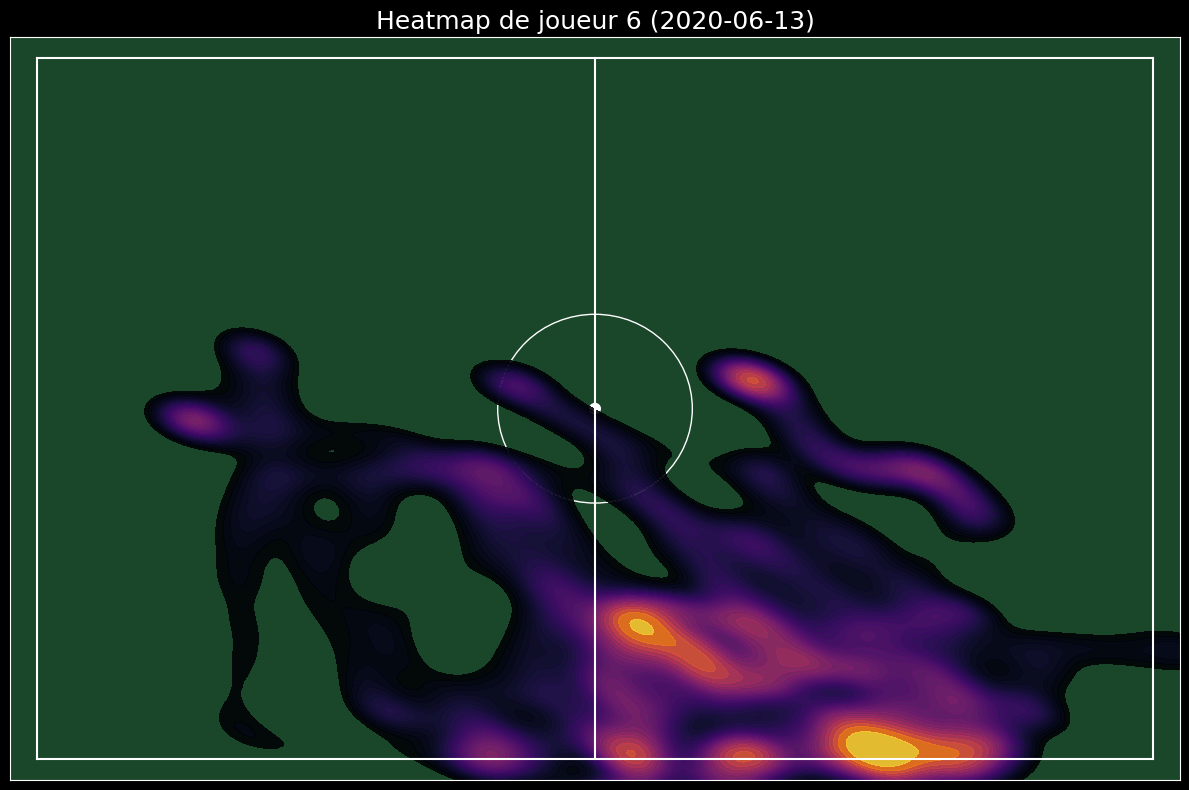

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Circle, Rectangle

# ===============================
# Paramètres
# ===============================
session_date = '2020-06-13'
player_pseudo = 6
sampling_rate = 20        # 1 point sur 20 pour réduire le volume de données

# ===============================
# Récupération données du joueur
# ===============================
players_df = con.execute(f"""
    SELECT
        t.x_pos - 55 AS x_smooth,
        t.y_pos - 36 AS y_smooth,
        s.position
    FROM tracking_clean t
    JOIN summary s
        ON t.sensor_id = s.Sensor
    WHERE t.session_type = 'game'
      AND t.session_date = '{session_date}'
      AND t.player_pseudo = {player_pseudo}
""").df()

# Nettoyage des données manquantes
players_df = players_df.dropna(subset=['x_smooth', 'y_smooth', 'position'])

# Sampling pour réduire le nombre de points
if len(players_df) > sampling_rate:
    players_df = players_df.iloc[::sampling_rate]

print("Positions uniques :", players_df['position'].unique())

# ===============================
# Création catégorie simplifiée
# ===============================
players_df['group_position'] = np.select(
    [
        players_df['position'].str.contains('back', case=False),
        players_df['position'].str.contains('midfield', case=False),
        players_df['position'].str.contains('forward', case=False)
    ],
    [
        'Defense',
        'Midfield',
        'Attack'
    ],
    default='Other'
)

print("Groupes créés :", players_df['group_position'].unique())

# ===============================
# Fonction pour dessiner le terrain
# ===============================
def draw_pitch(ax):
    ax.set_facecolor('#1a472a')

    # Contours
    ax.plot([0, 0], [-34, 34], color='white')
    ax.plot([-52.5, 52.5], [-34, -34], color='white')
    ax.plot([-52.5, 52.5], [34, 34], color='white')
    ax.plot([-52.5, -52.5], [-34, 34], color='white')
    ax.plot([52.5, 52.5], [-34, 34], color='white')

    # Cercle central
    ax.add_patch(Circle((0,0), 9.15, edgecolor='white', facecolor='none'))
    ax.add_patch(Circle((0,0), 0.5, color='white'))

    # Limites
    ax.set_xlim(-55, 55)
    ax.set_ylim(-36, 36)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

# ===============================
# Création figure
# ===============================
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 8))

# Dessiner le terrain
draw_pitch(ax)

# Affichage du nombre de points
print("Points du joueur :", len(players_df))

# ===============================
# Heatmap du joueur
# ===============================
if len(players_df) > 10:
    sns.kdeplot(
        x=players_df['x_smooth'],
        y=players_df['y_smooth'],
        fill=True,
        cmap="inferno",
        bw_adjust=0.7,   # ajuste la douceur
        thresh=0.05,      # ignore les zones très faibles
        levels=30,        # nombre de niveaux de couleur
        alpha=0.9,
        ax=ax
    )

ax.set_title(f'Heatmap de joueur {player_pseudo} ({session_date})', fontsize=18)
plt.tight_layout()
plt.show()
